In [1]:
import os
import sys
import time
import pickle
import itertools
import numpy as np
import pandas as pd

from itertools import islice
import matplotlib.pyplot as plt
from collections import Counter
from multiprocessing import Pool
from datetime import datetime, timedelta
from astropy.table import QTable, Table, Column
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler


import torch
torch.set_num_threads(6)
from torch.utils.data import DataLoader

Using TensorFlow backend.


### Loading Excel Sheet

In [2]:
xls = pd.ExcelFile("path to excel sheet") 
data_sheet1 = xls.parse(0)
data_sheet1= data_sheet1[:1913]
data_sheet1

,Pat-ID,"Cohort [0 = Inpatient, 1 = Outpatient]",Date,Hours included [h],SCC_all [Diagnose],SCC_all_start,"Regular day_all [1 = 'regular day', 0 = 'irregular day']",SCC_all_performance,SCC_infectious_start,"Regular day_infectious [1 = 'regular day', 0 = 'irregular day']",SCC_infectious_performance
0,1001,0.0,2018-11-09 00:00:00,4.416667,NaN,NaN,1.0,NaN,NaN,1.0,-4.0
1,1001,0.0,2018-11-10 00:00:00,24.000000,NaN,NaN,1.0,NaN,NaN,1.0,-3.0
2,1001,0.0,2018-11-11 00:00:00,24.000000,NaN,NaN,0.0,-2.0,NaN,0.0,-2.0
3,1001,0.0,2018-11-12 00:00:00,24.000000,NaN,NaN,0.0,-1.0,NaN,0.0,-1.0
4,1001,0.0,2018-11-13 00:00:00,24.000000,1.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1908,1079,1.0,2020-02-27 00:00:00,24.000000,NaN,NaN,1.0,NaN,NaN,1.0,NaN
1909,1079,1.0,2020-02-28 00:00:00,24.000000,NaN,NaN,1.0,NaN,NaN,1.0,NaN
1910,1079,1.0,2020-02-29 00:00:00,24.000000,NaN,NaN,1.0,NaN,NaN,1.0,NaN
1911,1079,1.0,2020-03-01 00:00:00,24.000000,NaN,NaN,1.0,NaN,NaN,1.0,NaN


### Getting  patients' IDs

In [3]:
pat_id = data_sheet1["Pat-ID"]
print(np.unique(pat_id.values))

[1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014
 1015 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027 1028
 1029 1030 1031 1032 1033 1034 1035 1036 1037 1038 1039 1040 1041 1042
 1043 1044 1045 1046 1047 1048 1049 1050 1051 1052 1053 1054 1055 1056
 1057 1058 1059 1060 1061 1062 1063 1064 1065 1066 1067 1068 1069 1070
 1071 1072 1073 1074 1075 1076 1077 1078 1079]


### Getting Label

In [4]:
is_regular = data_sheet1["Regular day_infectious [1 = 'regular day', 0 = 'irregular day']"]

### Getting date and making a dictionary  with key=[date, ID] and value=is_regular

In [8]:
date = data_sheet1["Date"]
print(date)

0       2018-11-09 00:00:00
1       2018-11-10 00:00:00
2       2018-11-11 00:00:00
3       2018-11-12 00:00:00
4       2018-11-13 00:00:00
               ...         
1908    2020-02-27 00:00:00
1909    2020-02-28 00:00:00
1910    2020-02-29 00:00:00
1911    2020-03-01 00:00:00
1912    2020-03-02 00:00:00
Name: Date, Length: 1913, dtype: object


In [9]:
Dict = {}
for i in range (len(date)):
    Dict[str([date[i].date(), pat_id[i]])]= is_regular[i]

### Getting Cohort [0 = Inpatient, 1 = Outpatient] and making a dictionary  with key=[date, ID] and value=cohort

In [10]:
cohort = data_sheet1["Cohort [0 = Inpatient, 1 = Outpatient]"]

In [11]:
Dict_cohort = {}
for i in range (len(date)):
    Dict_cohort[str([date[i].date(), pat_id[i]])]= cohort[i]

### Functions   

In [12]:
def num_samples(all_intervals):
    c = 0
    for i in range(len(all_intervals)):
        c +=1
    return c

def max_min_len(all_intervals):
    length_lst = []
    for i in range(len(all_intervals)):
        length_lst.append((all_intervals[i][0]).shape[0])
    return  [min(length_lst), max(length_lst)] 

def len_samples(all_intervals):
    length_lst = []
    for i in range(len(all_intervals)):
        length_lst.append((all_intervals[i][0]).shape[0])
    return  length_lst

def list_start_hour(all_intervals):
    start_hour = []
    for i in range(len(all_intervals)):
        start_hour.append((all_intervals[i][1]).hour)
    return start_hour    

### Reading Patients Data

In [13]:
file_path = 'path to .pkl files'

InPat_Pkl_list = []
for root, dirs, files in os.walk(file_path):
    for name in files:
        InPat_Pkl_list.append(name)
            
sorted(InPat_Pkl_list)

['H2017A_1055_190529_w50_merged.pkl',
 'H2017A_1056_190726_m64_merged.pkl',
 'H2017A_1057_190726_m50_merged.pkl',
 'H2017A_1058_190801_w69_merged.pkl',
 'H2017A_1059_190809_w58_merged.pkl',
 'H2017A_1060_190814_w50_merged.pkl',
 'H2017A_1061_190826_m69_merged.pkl',
 'H2017A_1062_190904_w44_merged.pkl',
 'H2017A_1063_190920_m73_merged.pkl',
 'H2017A_1064_190924_m52_merged.pkl',
 'H2017A_1065_191002_m69_merged.pkl',
 'H2017A_1066_191011_m52_merged.pkl',
 'H2017A_1067_191016_w21_merged.pkl',
 'H2017A_1068_191017_m62_merged.pkl',
 'H2017A_1069_191018_m49_merged.pkl',
 'H2017A_1070_191018_m62_merged.pkl',
 'H2017A_1071_191122_m57_merged.pkl',
 'H2017A_1072_191202_m60_merged.pkl',
 'H2017A_1073_191209_w54_merged.pkl',
 'H2017A_1074_191214_w44_merged.pkl',
 'H2017A_1075_200114_w54_merged.pkl',
 'H2017A_1076_200121_w44_merged.pkl',
 'H2017A_1077_200120_m48_merged.pkl',
 'H2017A_1078_200130_m54_merged.pkl',
 'H2017A_1079_200218_w54_merged.pkl']

In [17]:
length_lst = []
values_lst = []
max_len_lst = []
min_len_lst = []
estimated_total_num = []
s_h_in = []
for i in range(len(InPat_Pkl_list)):
    with open(os.path.join(file_path, InPat_Pkl_list[i]), 'rb') as fileobj:
        [all_intervals, num_skipped_intervals] = pickle.load(fileobj)
        values_lst.append(num_samples(all_intervals))
        max_len_lst.append(max_min_len(all_intervals)[1])
        min_len_lst.append(max_min_len(all_intervals)[0])
        length_lst.append(len_samples(all_intervals))
        s_h_in.append(list_start_hour(all_intervals))
        estimated_total_num.append((np.array(len_samples(all_intervals)).sum())//3600)
        
print(f'Total Number of Intervals:{np.array(values_lst).sum()}')  

Total Number of Intervals:7579


In [16]:
print(f'Estimated Total Number of Hours:{np.array(estimated_total_num).sum()}')

Estimated Total Number of Hours: 7187


### Plotting Number of Samples per Hour

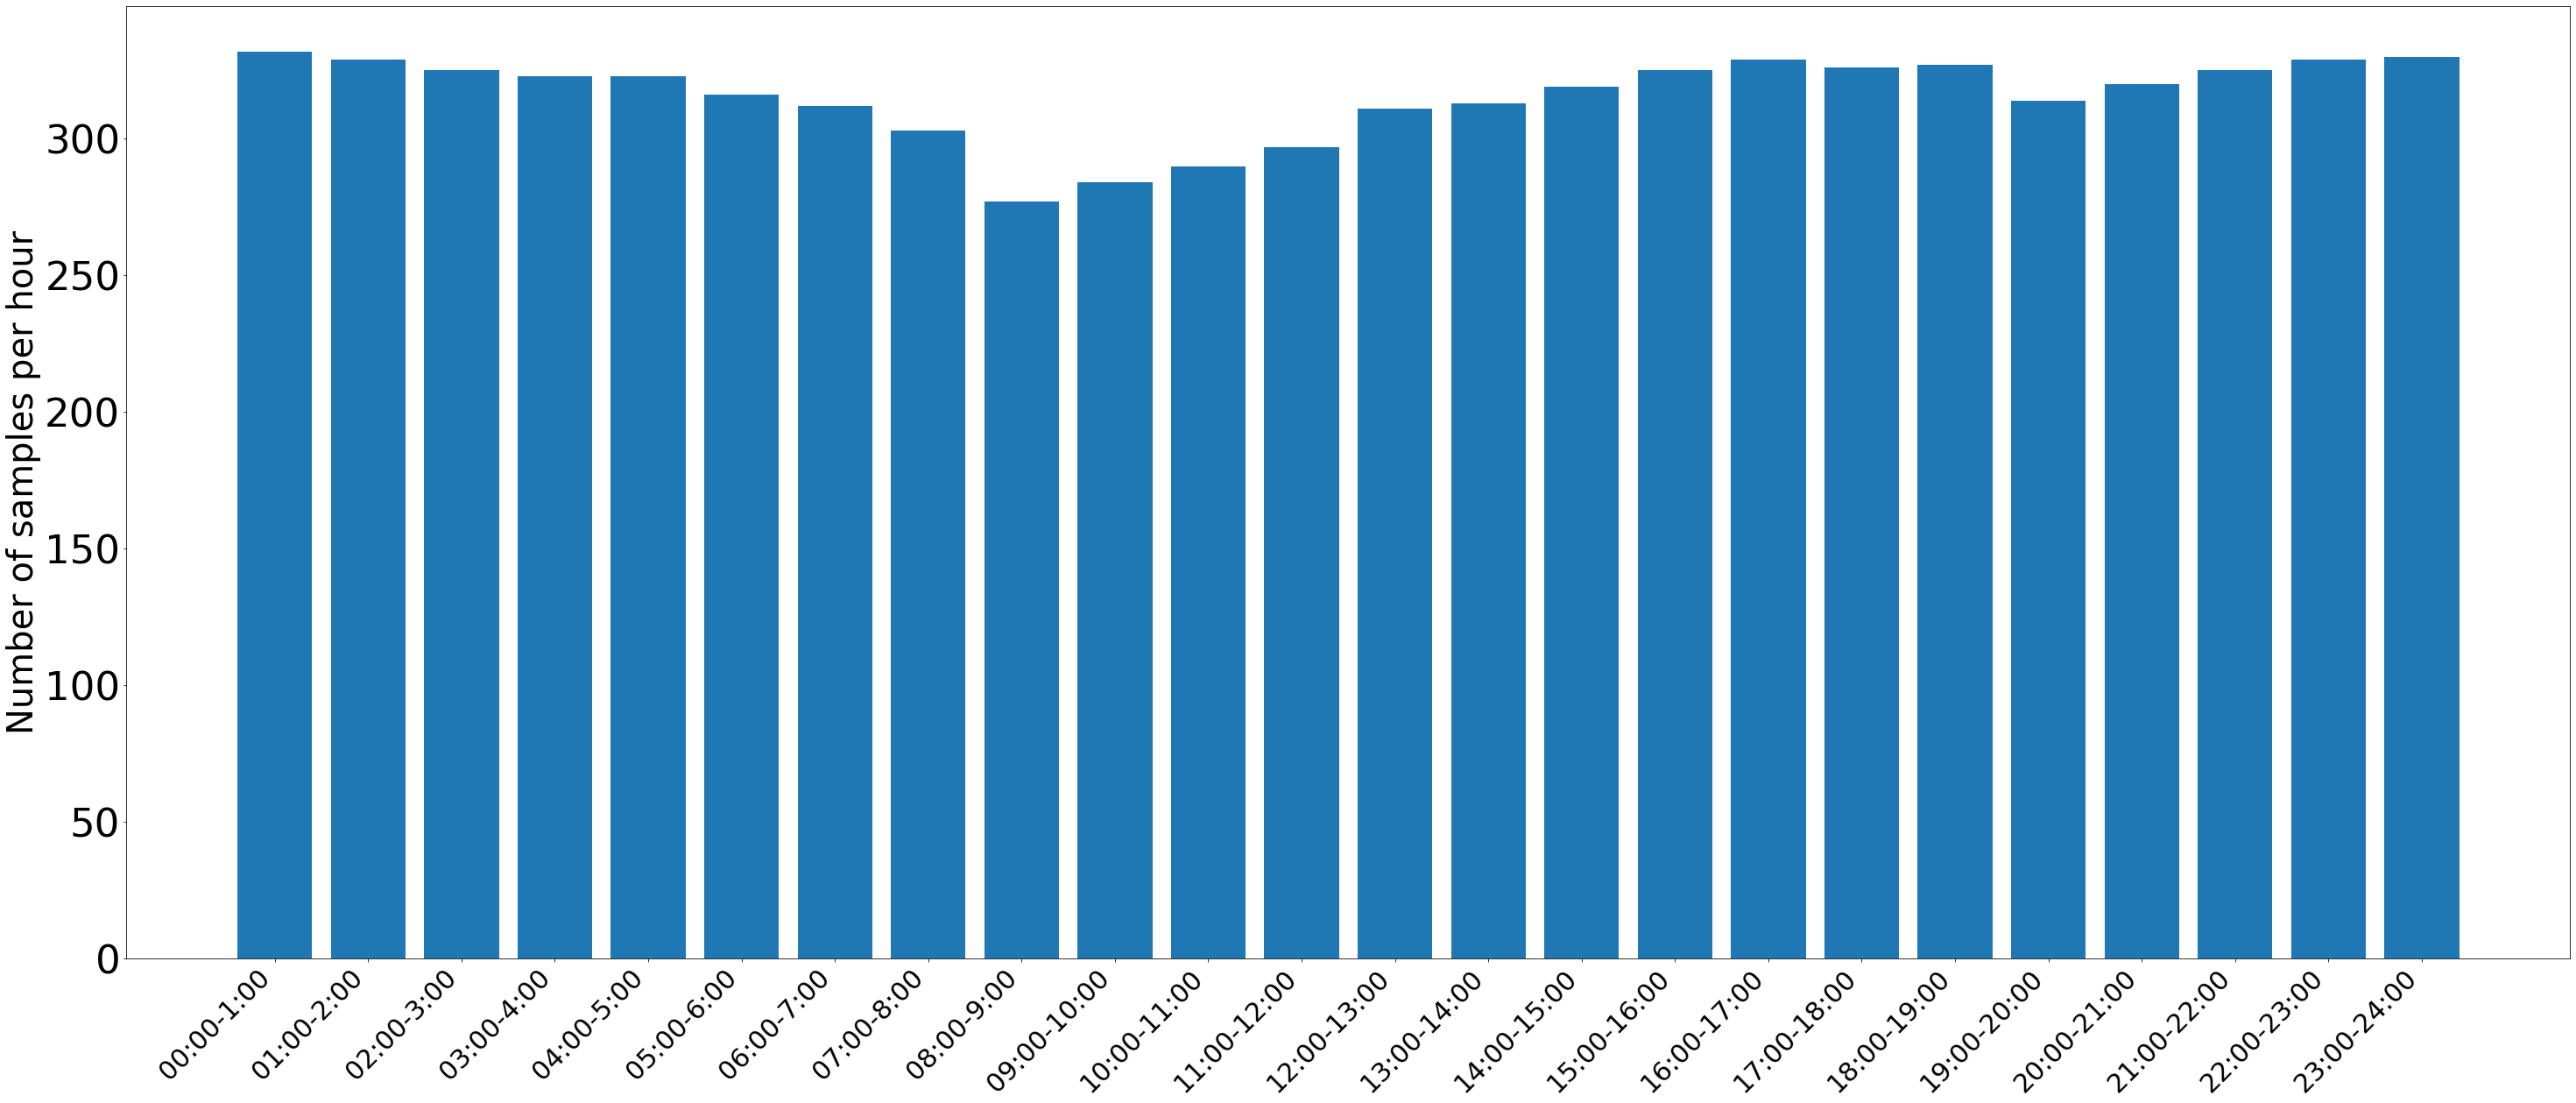

In [19]:
s_h_all = s_h_in
s_h_lst_merged = np.array(list(itertools.chain(*s_h_all)))
num = []
for i in range(0,24):
    num.append((1.0*(s_h_lst_merged==i)).sum())
    
h_lst = [f'0{i}:00-{i+1}:00' if i<10 else f'{i}:00-{i+1}:00' for i in range(0,24)]    

# Define plot space
fig, ax = plt.subplots(figsize=(50, 20))

# Create bar plot
ax.bar(h_lst, num)

ax.set_xticklabels(h_lst, rotation=45, ha="right", fontsize=30) 
plt.rc('ytick', labelsize=45)
plt.ylabel("Number of samples per hour", fontsize=40)
plt.show()

In [21]:
keys_lst = []
for i in range(len(InPat_Pkl_list)):
    keys_lst.append(InPat_Pkl_list[i].split('_')[1])

indices = np.argsort(keys_lst)
indices    
sorted_keys_lst = sorted(keys_lst)    
sorted_estimated_total_num = [estimated_total_num[i] for i in indices]   
t = Table([sorted_keys_lst, sorted_estimated_total_num], names=('Pat-ID', 'Total number of hours'))
print(t)


Pat-ID Total number of hours
------ ---------------------
  1055                   338
  1056                   339
  1057                   239
  1058                   271
  1059                   348
  1060                   195
  1061                   346
  1062                   263
  1063                   640
  1064                   315
   ...                   ...
  1069                   361
  1070                   343
  1071                   232
  1072                   120
  1073                   324
  1074                   254
  1075                   328
  1076                   321
  1077                   353
  1078                   217
  1079                   172
Length = 25 rows


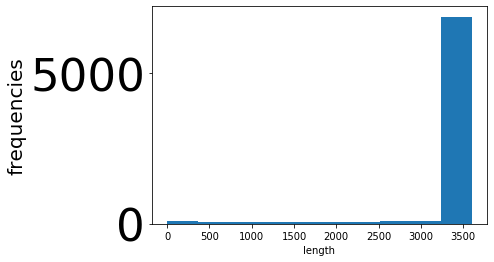

In [24]:
length_lst_merged = list(itertools.chain(*length_lst))
plt.figure()
plt.hist(length_lst_merged)
plt.xlabel("length")
plt.ylabel("frequencies", fontsize=20)
plt.show()

In [26]:
threshold = 2000.
length_ = []
for i in range(len(length_lst)):
    length_.append(int((1.*(np.array(length_lst[i])>=threshold)).sum()))
    
print(f'Nubmer of Samples whose Length>={threshold}:', np.array(length_).sum()) 
print('Eligible Intervals(%):', 100*((np.array(length_).sum())/(np.array(values_lst).sum())))

Nubmer of Samples whose Length>=2000.0: 7200
Eligible Intervals(%): 94.99934028235914


### adding is_regular  variable to data and saving them

In [27]:
L = 3000
all_data_regular = []
all_data_irregular = []
for i in range(len(InPat_Pkl_list)):
    with open(os.path.join(file_path, InPat_Pkl_list[i]), 'rb') as fileobj:
        [all_intervals, num_skipped_intervals] = pickle.load(fileobj)
    for i in range(len(all_intervals)):
        intervals = torch.tensor(all_intervals[i][0]) 
        s_t = all_intervals[i][1]
        e_t = all_intervals[i][2]
        ID = int(all_intervals[i][3])
        start_time = [s_t.year, s_t.month, s_t.day, s_t.hour, s_t.minute]
        end_time = [e_t.year, e_t.month, e_t.day, e_t.hour, e_t.minute]
        if str([s_t.date(), ID]) in Dict.keys():
            is_regular = Dict[str([s_t.date(), ID])]
            length = len(all_intervals[i][0])
            if length>=L:
                if is_regular==1:
                    all_data_regular.append([all_intervals[i][0][:L, :],
                                     ID, is_regular, np.array(start_time), np.array(end_time)])
                if is_regular==0:
                    all_data_irregular.append([all_intervals[i][0][:L, :],
                                     ID, is_regular, np.array(start_time), np.array(end_time)])    
print(len(all_data_irregular))    
print(len(all_data_regular)) 

1553
5402


In [29]:
loader = DataLoader(all_data_regular, batch_size=len(all_data_regular), shuffle=True, num_workers=0)
x, ID, is_regular, _, _ = next(iter(loader))

print(sorted(Counter(np.array(ID)).items())) 

[(1055, 228), (1056, 163), (1057, 230), (1058, 91), (1059, 340), (1060, 191), (1061, 60), (1062, 219), (1063, 384), (1064, 301), (1065, 114), (1066, 100), (1067, 203), (1068, 222), (1069, 176), (1070, 332), (1071, 224), (1072, 119), (1073, 164), (1074, 244), (1075, 322), (1076, 254), (1077, 345), (1078, 208), (1079, 168)]


In [30]:
loader = DataLoader(all_data_irregular, batch_size=len(all_data_irregular), shuffle=True, num_workers=0)
x, ID, is_regular, _, _ = next(iter(loader))

print(sorted(Counter(np.array(ID)).items()))

[(1055, 98), (1056, 158), (1058, 172), (1061, 278), (1062, 36), (1063, 231), (1065, 88), (1067, 117), (1069, 171), (1073, 149), (1076, 55)]


### Splitting Regular Data into train/test (90/10%)

In [31]:
train_set, test_set = train_test_split(all_data_regular, test_size=0.1, shuffle=True)
print('len(train_set):', len(train_set))
print('len(test_set):', len(test_set))

train_set_label = []
for i in range(len(train_set)):
    train_set_label.append(train_set[i][-4]) 
    
# ros = RandomOverSampler()
# X_resampled_train, y_resampled_train = ros.fit_resample(train_set, train_set_label)
# print(sorted(Counter(train_set_label).items())) 
# print(len(X_resampled_train))

len(train_set): 4861
len(test_set): 541


In [ ]:
path = "path for saving the data"

with open(f'{path}/train_set.pickle', 'wb') as output:
    pickle.dump(train_set, output)

with open(f'{path}/test_set.pickle', 'wb') as output:
    pickle.dump(test_set, output) 
    
with open(f'{path}/ood_set.pickle', 'wb') as output:
    pickle.dump(all_data_irregular, output)  